# Callin Switzer
### 12 Dec 2018
___
### - Train Dense, Feedforward Neural Network with Keras
### - Use data that was generated in Python

___

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
import winsound
import pickle
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
randomRawData = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\PythonGeneratedData\TrainingData'
if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


C:\Users\calli\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2019-04-05 08:35:39.666933


# Make training and test set

In [2]:
# read in data
trainDF = pd.read_hdf(os.path.join(dataOutput, "concatenatedRandomICs.h5"), key = "data")

In [3]:
print(trainDF.shape)
trainDF.head()

(9900510, 19)


,x0,xf,xd0,xdf,y0,yf,yd0,ydf,theta0,thetaf,thetad0,thetadf,phi0,phif,phid0,phidf,F,alpha,tau0
0,0.0,23.367432,1240.975696,1047.460389,0.0,-2.222497,-321.289498,-38.377027,4.539917,6.334514,5.761704,166.050842,2.909070,4.628560,10.607821,162.092739,29718.210402,3.057406,53852.149654
1,0.0,-20.768748,-1149.257088,-1075.409015,0.0,11.106142,365.093207,697.828947,3.243816,4.921125,16.957561,146.364185,3.308109,4.891662,22.615302,141.667777,28169.483755,3.504285,66579.923810
2,0.0,-25.280989,-1496.313673,-1133.713595,0.0,4.318522,244.869357,748.985152,5.436117,-0.270820,7.760703,-563.122968,5.548527,-0.137526,0.328348,-561.725041,42042.954099,1.460073,-13638.356558
3,0.0,-5.931729,-560.948725,-26.956023,0.0,0.748787,86.858301,45.961219,4.004344,4.826500,-0.067853,72.504068,0.510978,1.423037,24.197259,77.007517,32817.596791,1.943183,-59677.690610
4,0.0,-9.280447,-214.455052,-539.671502,0.0,6.707153,225.808462,488.013492,6.129205,4.399997,-16.195650,-177.812751,1.609007,-0.231868,9.118306,-183.140660,35120.738164,3.267484,77836.665059


In [4]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "xf" : "x_99", "yf" : "y_99", "phif" : "phi_99", "thetaf" : "theta_99", 
                        "xd0" : "x_dot_0", "yd0" : "y_dot_0", "phid0" : "phi_dot_0", "thetad0": "theta_dot_0", 
                        "xdf" : "x_dot_99", "ydf": "y_dot_99", "phidf": "phi_dot_99", "thetadf": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [5]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

In [6]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [7]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,2.909070,4.539917,23.367432,-2.222497,4.628560,6.334514,1240.975696,-321.289498,10.607821,5.761704
1,3.308109,3.243816,-20.768748,11.106142,4.891662,4.921125,-1149.257088,365.093207,22.615302,16.957561
2,5.548527,5.436117,-25.280989,4.318522,-0.137526,-0.270820,-1496.313673,244.869357,0.328348,7.760703
3,0.510978,4.004344,-5.931729,0.748787,1.423037,4.826500,-560.948725,86.858301,24.197259,-0.067853
4,1.609007,6.129205,-9.280447,6.707153,-0.231868,4.399997,-214.455052,225.808462,9.118306,-16.195650


In [8]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-29612.961122,2498.912376,53852.149654,1047.460389,-38.377027,162.092739,166.050842
1,-26336.915345,-9994.333651,66579.923810,-1075.409015,697.828947,141.667777,146.364185
2,4645.636361,41785.500502,-13638.356558,-1133.713595,748.985152,-561.725041,-563.122968
3,-11940.326951,30568.337400,-59677.690610,-26.956023,45.961219,77.007517,72.504068
4,-34842.795622,-4409.744037,77836.665059,-539.671502,488.013492,-183.140660,-177.812751


In [9]:
# test train split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [10]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

In [11]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,-0.479611,0.002266,-0.318639,-0.229442,-0.094704,0.071486,-0.491811,-0.220474,0.168732,0.450440
1,-0.453551,0.264615,0.295886,0.197180,-0.188053,0.054898,0.469097,0.195148,0.353807,-0.446865
2,-0.102133,-0.139825,0.314624,0.345313,-0.234415,-0.252743,0.486725,0.399421,0.036643,-0.265189
3,-0.025410,0.473391,-0.026110,0.073530,0.050494,0.209861,-0.032577,-0.026313,-0.037384,-0.004011
4,0.492691,-0.269698,-0.131405,0.348033,0.118454,-0.135028,-0.191459,0.408163,-0.416592,-0.057925


In [12]:
# save scalers, to be used on test set
scalerfileX = 'scalerX.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

# Keras models

In [13]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


In [14]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [15]:
K.clear_session()

In [16]:
# create network
def create_network(optimizer = 'rmsprop', dropout_rate=0.1, 
                  numUnits = 400, 
                  NumHiddenLayers = 3, 
                  weightRegularization = 0.0, 
                  secondToLastUnits = 16):
    K.clear_session()
    
    inputs = Input(shape=(Xtrain_scaled.shape[1],))
    x = Dense(numUnits, activation='tanh')(inputs)
    x = Dropout(dropout_rate)(x)
    
    for ii in np.arange(1, NumHiddenLayers + 1):
        x = Dense(numUnits, activation='tanh', 
                  kernel_regularizer=regularizers.l1(weightRegularization))(x)
        x = Dropout(dropout_rate)(x)
    
    x = Dense(secondToLastUnits, activation='tanh')(x)
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [17]:
Xtrain_scaled_small = Xtrain_scaled[0:8000, :]
Ytrain_scaled_small = Ytrain_scaled[0:8000, :]

In [18]:
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=20, 
                          verbose=1, mode='auto', min_delta = 0.0001)

model = KerasRegressor(build_fn=create_network, verbose=0)
fit_params = dict(callbacks=[earlystop])

In [19]:
K.clear_session()

model = create_network(optimizer = "rmsprop", 
                        dropout_rate=0.0, 
                        numUnits = 512, 
                        NumHiddenLayers = 1, 
                        weightRegularization = 0, 
                        secondToLastUnits = 32)


In [20]:
model = create_network(optimizer = "rmsprop", 
                        dropout_rate=0.0, 
                        numUnits = 800, 
                        NumHiddenLayers = 2, 
                        weightRegularization = 0, 
                        secondToLastUnits = 16)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 800)               8800      
_________________________________________________________________
dropout_1 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 800)               640800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 800)               640800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 800)               0         
__________

In [22]:
#model.get_config()
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=150, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [28]:
stt = time.time()
history = model.fit(Xtrain_scaled, Ytrain_scaled, epochs = 1500, verbose = 2, 
                        batch_size =2**14, callbacks = [earlystop], validation_split = 0.3)
# history = model.fit(Xtrain_scaled, Ytrain_scaled, epochs = 1500, verbose = 2, 
#                         batch_size =512, callbacks = [earlystop], validation_split = 0.3)
# Probably play Windows default sound, if any is registered (because
# "*" probably isn't the registered name of any sound).
winsound.PlaySound("*", winsound.SND_ALIAS)
endd = time.time() - stt
print(endd)

Train on 5544285 samples, validate on 2376123 samples
Epoch 1/1500
 - 11s - loss: 3.9558e-04 - mean_squared_error: 3.9558e-04 - val_loss: 3.6349e-04 - val_mean_squared_error: 3.6349e-04
Epoch 2/1500
 - 11s - loss: 4.0153e-04 - mean_squared_error: 4.0153e-04 - val_loss: 3.7015e-04 - val_mean_squared_error: 3.7015e-04
Epoch 3/1500
 - 11s - loss: 3.8231e-04 - mean_squared_error: 3.8231e-04 - val_loss: 3.5434e-04 - val_mean_squared_error: 3.5434e-04
Epoch 4/1500
 - 11s - loss: 4.0487e-04 - mean_squared_error: 4.0487e-04 - val_loss: 4.2409e-04 - val_mean_squared_error: 4.2409e-04
Epoch 5/1500
 - 11s - loss: 3.8941e-04 - mean_squared_error: 3.8941e-04 - val_loss: 2.7875e-04 - val_mean_squared_error: 2.7875e-04
Epoch 6/1500
 - 11s - loss: 3.8104e-04 - mean_squared_error: 3.8104e-04 - val_loss: 3.1539e-04 - val_mean_squared_error: 3.1539e-04
Epoch 7/1500
 - 11s - loss: 3.8143e-04 - mean_squared_error: 3.8143e-04 - val_loss: 3.6104e-04 - val_mean_squared_error: 3.6104e-04
Epoch 8/1500
 - 11s - 

In [29]:
history.history['val_loss'][-1]# MSE for final epoch testing
# not sure why it's different from MSE vs. loss????  answer : I think loss incorporates regularization. 

0.00023712440852708026

In [25]:
history.history['val_mean_squared_error'][-1] # it is the same when there is no regularization

0.0006754225494877889

In [ ]:
history.history['loss'][-1]# MSE for final epoch training

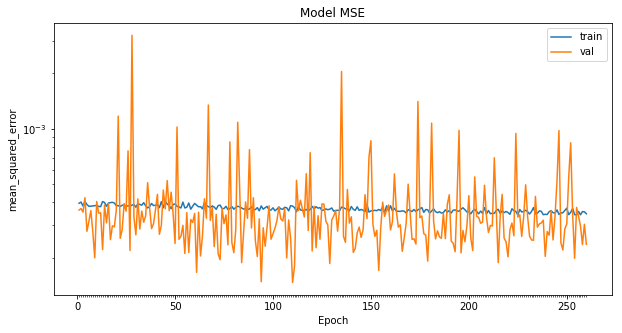

In [30]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_2343Params.png"), dpi = 120, bbox_inches='tight')
    plt.yscale('log') #logarithmic scale for y axis
    plt.show()
    
plot_model_history(history, saveFig=True)

In [ ]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_2343Params.png"), dpi = 120, bbox_inches='tight')
    plt.yscale('log') #logarithmic scale for y axis
    plt.show()
    
plot_model_history(history, saveFig=True)

In [31]:
# save model
model.save(os.path.join(savedModels, 'my_model_400Units_newData.h5'))

In [ ]:
print("hello")

In [ ]:
savedModels

In [ ]:
# check to see if model saved: 
K.clear_session()
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model_512Units.h5'))

In [ ]:
model.evaluate(Xtest_scaled, Ytest_scaled)

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (40, 60), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
K.clear_session()

In [ ]:
# this is the original model
inputs = Input(shape=(Xtrain_scaled.shape[1],))
x = Dense(400, activation='tanh')(inputs)
x = Dense(400, activation='tanh')(x)
x = Dense(400, activation='tanh')(x)
x = Dense(16, activation='tanh')(x)
predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

# create model
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss="mse", optimizer="adam", metrics = ['mse'])

earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=50, 
                          verbose=1, mode='auto', min_delta = 0.001)

In [ ]:
# start training
history = model.fit(Xtrain_scaled_small, Ytrain_scaled_small, validation_split = 0.3, 
                    verbose = 2, batch_size=2**14, epochs = 200, 
                    callbacks = [earlystop])

In [ ]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining.png"), dpi = 120, bbox_inches='tight')
    plt.show()
    
plot_model_history(history)
print(history.history["loss"][-1])

In [ ]:
# load model that was trained for much longer
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model.h5'))

In [ ]:
model.summary()

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((15, 6)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 30)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 30)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()
#fig.savefig(os.path.join(figDir, "SmallModelResids.png"), dpi = 120, bbox_inches='tight')


In [ ]:
# trim distribution of weights -- cut out middle 20%
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (40, 60), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# show new histogram of weights (excluding the 0's)
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15, 6)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    
    d1 = wts[jj].reshape(-1)
    axs[jj].hist(d1[d1!=0], bins = 30, facecolor = '#d6bddb' )
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))

    d2 = wts[jj+1]
    axs[jj+1].hist(d2[d2!=0], bins = 30, facecolor = '#d6bddb')
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# the validation.split is the last X% of the data
int(0.3*Xtrain_scaled.shape[0])
ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()
